In [1]:
# import the needed packages
# from result_fusion import Fusion
from result_fusion import Fusion2
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from tools.iou_perimg import SegmentationMetrics
import tqdm
import config

In [2]:

# define the folder path and parameters
# train2 is the folder of the generated mask, preciser
# train is the folder of the generated mask, default sam params
mask_folder = config.mask_folder
# the path to the model prediction
# segmentation_root = '/media/ywh/1/yanweihao/projects/uda/DAFormer/work_dirs'
segmentation_folder = config.segmentation_folder
confidence_folder = config.confidence_folder
entropy_folder = config.entropy_folder
# segmentation_folder = '/media/ywh/1/yanweihao/projects/uda/MIC/seg/work_dirs/local-basic/230509_1455_gtaHR2csHR_mic_hrda_s2_108c1/pred_trainid'
# the path to the original image
image_folder = config.image_folder
# the path to the ground truth
gt_folder = config.gt_folder

# 
mix_ratio = config.mix_ratio
# 
resize_ratio = config.resize_ratio
# 
output_folder = config.output_folder #这是去掉了mask按照名称排序的过程
# 
mask_suffix = config.mask_suffix
# 
# segmentation_suffix = '_gtFine_labelTrainIds.png'
# segmentation_suffix = '_leftImg8bittrainID.png'
segmentation_suffix = config.segmentation_suffix
#
segmentation_suffix_noimg = config.segmentation_suffix_noimg
#
confidence_suffix = config.confidence_suffix
entropy_suffix = config.entropy_suffix
confidence_threshold = config.confidence_threshold  # absolute value
entropy_ratio = config.entropy_ratio  # relative value, lowest 70% entropy
#
gt_suffix = config.gt_suffix

# fusion mode = 1
# fusion_mode = 0
fusion_mode = config.fusion_mode
# 
sam_classes = config.sam_classes  # 11 classes, 5, 6, 7, 
# 
shrink_num = config.shrink_num
# 
display_size = config.display_size
# whether to save the mixed result
save_mix_result = config.save_mix_result

the path is already exist
the path is already exist
the path is already exist
the path is already exist
the path is already exist
the path is already exist


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.99s/it]


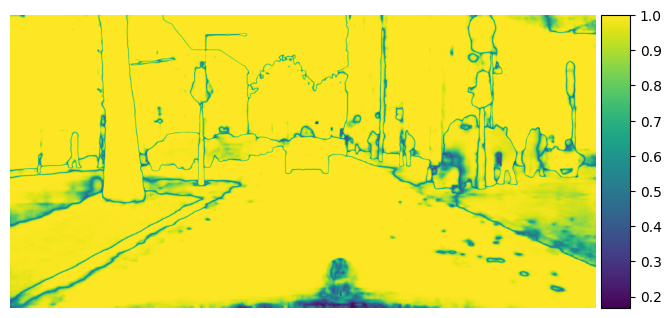

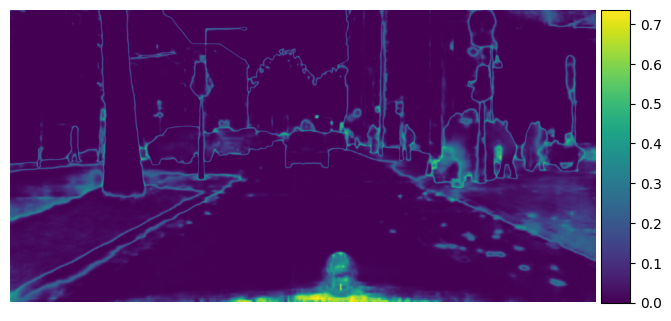

In [3]:
fusion = Fusion2(mask_folder, segmentation_folder, confidence_folder, entropy_folder, \
                image_folder, gt_folder, \
                mix_ratio, resize_ratio, output_folder, mask_suffix, \
                segmentation_suffix, segmentation_suffix_noimg, \
                confidence_suffix, entropy_suffix, gt_suffix, \
                fusion_mode, sam_classes, shrink_num, display_size)

debug_num = 1 # 2975
begin_index = 29 # 0
index_range = list(range(begin_index, begin_index + debug_num))
iou_cal = SegmentationMetrics()

bar = tqdm.tqdm(total=debug_num)
for i in index_range:
    image_name = fusion.image_names[i]  # aachen_000000_000019_leftImg8bit
    # get the prediction
    prediction_path = os.path.join(fusion.segmentation_folder, \
        image_name.replace('_leftImg8bit', '') + fusion.segmentation_suffix)
    if fusion.segmentation_suffix_noimg:
        prediction_path = prediction_path.replace('_leftImg8bit', '')
    pred = cv2.imread(prediction_path) #[h, w, 3], 3 channels not 1 channel
    pred_color = fusion.color_segmentation(pred[:,:,0])
    
    # get the confidence map
    confidence_path = os.path.join(fusion.confidence_folder, \
        image_name + fusion.confidence_suffix)
    pred_confidence = np.load(confidence_path) #[h, w]
    
    # get the entropy map
    entropy_path = os.path.join(fusion.entropy_folder, \
        image_name + fusion.entropy_suffix)
    pred_entropy = np.load(entropy_path) #[h, w]
    
    # get the ground truth
    gt_path = os.path.join(fusion.gt_folder, \
        image_name.replace('_leftImg8bit', '') + fusion.gt_suffix)
    gt = cv2.imread(gt_path) #[h, w, 3]
    # print(np.unique(gt))
    gt_color = fusion.color_segmentation(gt[:,:,0])

    #get the original image
    original_image = cv2.imread(os.path.join(fusion.image_folder, \
        image_name + fusion.mask_suffix))

    # get the confidence map and entropy map
    pred_confidence = pred_confidence.astype(np.float32)
    pred_entropy = pred_entropy.astype(np.float32)
    confidence_map = fusion.visualize_numpy(pred_confidence)
    entropy_map = fusion.visualize_numpy(pred_entropy)
    confidence_mask, confidence_img = fusion.visualize_numpy_higher_threshold(pred_confidence, 
                                                            original_image, confidence_threshold)
    entropy_threshold = np.percentile(pred_entropy, entropy_ratio)
    entropy_mask, entropy_img = fusion.visualize_numpy_lower_threshold(pred_entropy, 
                                                         original_image, entropy_threshold)

    #get the sam segmentation result using the mask
    sam_pred = fusion.get_sam_pred(image_name, pred, entropy_mask)  # [h,w]
    sam_color = fusion.color_segmentation(sam_pred)  # [h,w,3]

    #get the sam mixed color image using the fusion.mix_ratio
    sam_mixed_color = cv2.addWeighted(original_image, \
        fusion.mix_ratio, sam_color, 1 - fusion.mix_ratio, 0)
    if fusion.resize_ratio != 1:
        sam_mixed_color = cv2.resize(sam_mixed_color, \
        (int(sam_mixed_color.shape[1] * fusion.resize_ratio), \
        int(sam_mixed_color.shape[0] * fusion.resize_ratio)), \
        interpolation=cv2.INTER_NEAREST)

    if save_mix_result:
        #save the sam mask in trainid and color to the output folder
        cv2.imwrite(os.path.join(fusion.output_folder, 'trainID', image_name + fusion.mask_suffix), sam_pred)
        # cv2.imwrite(os.path.join(fusion.output_folder, 'color', image_name + fusion.mask_suffix), fusion_color)
        cv2.imwrite(os.path.join(fusion.output_folder, 'mixed', image_name + fusion.mask_suffix), sam_mixed_color)
    
        if fusion.fusion_mode == 1:
            fusion_trainid_bg, fusion_color_bg = fusion.fusion_mode_1(segmentation=pred, sam_pred=sam_pred)
        elif fusion.fusion_mode == 2:
            fusion_trainid_bg, fusion_color_bg = fusion.fusion_mode_2(segmentation=pred, sam_pred=sam_pred)
        elif fusion.fusion_mode == 3:
            fusion_trainid_bg, fusion_color_bg = fusion.fusion_mode_3(segmentation=pred, sam_pred=sam_pred)
        elif fusion.fusion_mode == 4:
            fusion_trainid_bg, fusion_color_bg = fusion.fusion_mode_4(segmentation=pred, sam_pred=sam_pred, confidence_mask=confidence_mask)
        elif fusion.fusion_mode == 5:
            fusion_trainid_bg, fusion_color_bg = fusion.fusion_mode_5(segmentation=pred, sam_pred=sam_pred, entropy_mask=entropy_mask)
        else:
            # raise NotImplementedError
            raise NotImplementedError("This fusion mode has not been implemented yet.")
    
        #save the fusion mask in trainid and color to the output folder
        mixed_color_bg = cv2.addWeighted(original_image, fusion.mix_ratio, fusion_color_bg, 1 - fusion.mix_ratio, 0)
        if fusion.resize_ratio != 1:
            mixed_color_bg = cv2.resize(mixed_color_bg, (int(mixed_color_bg.shape[1] * fusion.resize_ratio), int(mixed_color_bg.shape[0] * fusion.resize_ratio)), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(os.path.join(fusion.output_folder, 'trainID_bg', image_name + fusion.mask_suffix), fusion_trainid_bg)
        # cv2.imwrite(os.path.join(fusion.output_folder, 'color_bg', image_name + fusion.mask_suffix), fusion_color_bg)
        cv2.imwrite(os.path.join(fusion.output_folder, 'mixed_bg', image_name + fusion.mask_suffix), mixed_color_bg)

    #get fusion result from 1, 2, 3, 4, 5
    fusion_trainid_bg_1, fusion_color_bg_1 = \
        fusion.fusion_mode_1(segmentation=pred, sam_pred=sam_pred)
    fusion_trainid_bg_2, fusion_color_bg_2 = \
        fusion.fusion_mode_2(segmentation=pred, sam_pred=sam_pred)
    fusion_trainid_bg_3, fusion_color_bg_3 = \
        fusion.fusion_mode_3(segmentation=pred, sam_pred=sam_pred, \
                             fusion_trainid_0=fusion_trainid_bg_1, fusion_color_0=fusion_color_bg_1)
    fusion_trainid_bg_4, fusion_color_bg_4 = \
        fusion.fusion_mode_4(segmentation=pred, sam_pred=sam_pred, \
                             confidence_mask=confidence_mask, fusion_trainid=fusion_trainid_bg_3)
    fusion_trainid_bg_5, fusion_color_bg_5 = \
        fusion.fusion_mode_5(segmentation=pred, sam_pred=sam_pred, entropy_mask=entropy_mask)
    
    miou_1, ious_1 = iou_cal.calculate_miou(fusion_trainid_bg_1, gt[:,:,0])
    miou_2, ious_2 = iou_cal.calculate_miou(fusion_trainid_bg_2, gt[:,:,0])
    miou_3, ious_3 = iou_cal.calculate_miou(fusion_trainid_bg_3, gt[:,:,0])
    miou_4, ious_4 = iou_cal.calculate_miou(fusion_trainid_bg_4, gt[:,:,0])
    miou_5, ious_5 = iou_cal.calculate_miou(fusion_trainid_bg_5, gt[:,:,0])
    
    error_1 = fusion.get_error_image(fusion_trainid_bg_1, gt[:,:,0], fusion_color_bg_1)
    error_2 = fusion.get_error_image(fusion_trainid_bg_2, gt[:,:,0], fusion_color_bg_2)
    error_3 = fusion.get_error_image(fusion_trainid_bg_3, gt[:,:,0], fusion_color_bg_3)
    error_4 = fusion.get_error_image(fusion_trainid_bg_4, gt[:,:,0], fusion_color_bg_4)
    error_5 = fusion.get_error_image(fusion_trainid_bg_5, gt[:,:,0], fusion_color_bg_5)
    
    # fusion.display_images_horizontally([gt_color, sam_color, pred_color, fusion_color_bg_0], '{}_fusion0'.format(image_name.replace('_leftImg8bit', '')), miou_0)
    fusion.display_images_horizontally(
        [original_image, gt_color, sam_color, pred_color, \
        fusion_color_bg_1, fusion_color_bg_2, fusion_color_bg_3, fusion_color_bg_5, \
        error_1, error_2, error_3, error_5, \
        confidence_map, entropy_map, confidence_img, entropy_img], \
        '{}'.format(image_name.replace('_leftImg8bit', '')), \
        [(miou_1, ious_1), (miou_2, ious_2), (miou_3, ious_3), (miou_5, ious_5)], \
        [confidence_threshold, entropy_threshold])
    fusion.save_ious(miou_1, ious_1, miou_2, ious_2,  miou_3, ious_3,miou_5, ious_5, \
        '{}'.format(image_name.replace('_leftImg8bit', '')))
    bar.update(1)
bar.close()
 